In [40]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch
from sebm.data import setup_data_loader
from sebm.utils import load_models, init_models, plot_samples
from sebm.sgld import SGLD_Sampler

model_name = 'GCEBM' # "VAE", "CEBM"
data = 'grassymnist_grass'
dataset_args = {'data': data, 
                'data_dir': '../data/', 
                'batch_size': 100,
                'train': True, 
                'normalize': False if model_name=='VAE' else True}
train_loader, im_h, im_w, im_channels = setup_data_loader(**dataset_args)
num_classes = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
device = 'cpu'
lr = 5e-5
reg_alpha = 5e-3
seed = 2
gamma = 10.0
latent_dim = 128
data_noise = 3e-2
network_args = {'device': device,
                'im_height': im_h, 
                'im_width': im_w, 
                'input_channels': im_channels, 
                'channels': [32,32,64,64], 
                'kernels': [3,4,4,4], 
                'strides': [1,2,2,2], 
                'paddings': [1,1,1,1],
                'hidden_dims': [256],
                'latent_dim': latent_dim,}

if model_name in ['GCEBM', 'CEBM', 'SUPCEBM', 'GCEBM-restore']:
    network_args['activation'] = 'SiLU'
    if model_name == 'SUPCEBM':
        network_args['num_classes'] = num_classes

    exp_name = '{}_d={}_z={}_lr={}_act=SiLU_sgld_s=60_n=0.0075_a=2.0_dn={}_reg={}_seed={}'.format(model_name, data, latent_dim, lr, data_noise, reg_alpha, seed)
    if model_name in ['GCEBM', 'SUPCEBM','GCEBM-restore']:
        exp_name += '_gamma={}_hacky'.format(gamma)

elif model_name in ['VAE']:
    exp_name = '{}_d={}_z=128_lr=0.001_act=ReLU_seed={}'.format(model_name, data, seed)
    network_args['activation'] = 'ReLU'
    network_args['dec_paddings'] = [1,1,0,0]

models = init_models(model_name, device, network_args)
load_models(models, exp_name, map_location=torch.device(device))

In [42]:
sgld_args = {'im_h': network_args['im_height'], 
             'im_w':  network_args['im_width'], 
             'im_channels':  network_args['input_channels'],
             'device': device,
             'alpha': 2.0,
             'noise_std': 5e-3,
             'buffer_size': 1,
             'reuse_freq': 1}
sgld_sampler = SGLD_Sampler(**sgld_args)

def both_energy(x):
    return models['cebm_fg'].energy(x) + models['cebm_bg'].energy(x)

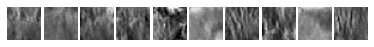

In [49]:
images_ebm = sgld_sampler.sample(models['cebm_bg'].energy, 
                                 batch_size=10, 
                                 num_steps=500,
                                 pcd=False)
plot_samples(images_ebm, denormalize=True, save_name=None)  

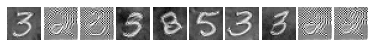

In [57]:
sample_name = 'gcebm_ave'
images_ebm = sgld_sampler.sample(models['cebm_fg'].energy, 
                                 batch_size=10, 
                                 num_steps=500,
                                 pcd=False,)
plot_samples(images_ebm, denormalize=True, save_name=None)#'{}_fg'.format(sample_name))  

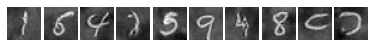

In [56]:
images_ebm = sgld_sampler.sample(both_energy, 
                                 batch_size=10, 
                                 num_steps=500,
                                 pcd=False)
plot_samples(images_ebm, denormalize=True, save_name=None)  